Лабораторная работа номер 6. Выполнил студент ННбд-01-22 Бабенко Роман

Задачи:

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

2. Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

3. Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

Задача 1.

In [4]:
# модель градиентного бустинга из лабы

from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

# "игрушечный" датасет
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

# обучающая и тестовая выборка
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)


def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        prediction = 0
        for alg in trees_list:
            prediction += eta * alg.predict([x])[0]
        predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

# mse как функционал ошибки
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

# L2 loss производная
def residual(y, z):
    return - (z - y)

# функция градиентного бустинга
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь рассмотрим зависимость ошибки от количества деревьев

In [22]:
# Число деревьев в ансамбле будем считать от одного до 70 с шагом 10
n_trees = [10, 15, 20, 25, 30]

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)
    test_prediction = gb_predict(X_test, trees, eta)
    return [mean_squared_error(y_train, train_prediction), mean_squared_error(y_test, test_prediction)]

rez = []

for n_t in n_trees:
    trees, train_errors, test_errors = gb_fit(n_t, max_depth, X_train, X_test, y_train, y_test, eta)
    rez.append(evaluate_alg(X_train, X_test, y_train, y_test, trees, eta))

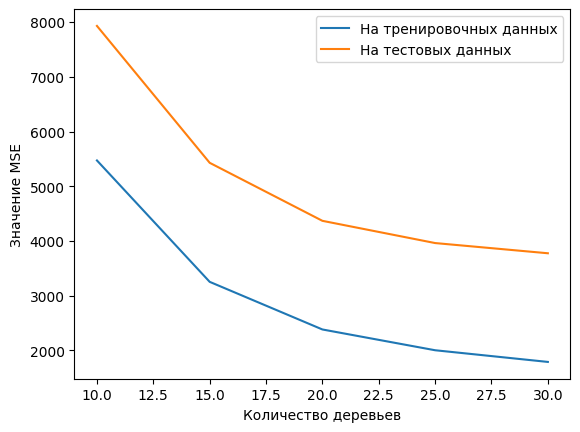

In [23]:
# строим график
plt.xlabel('Количество деревьев')
plt.ylabel('Значение MSE')
plt.plot(n_trees, [i[0] for i in rez], label='На тренировочных данных')
plt.plot(n_trees, [i[1] for i in rez], label='На тестовых данных')
plt.legend(loc='upper right')
plt.show()

Я рассмотрел количество деревьев в ансамбле - 10, 15, 20, 25, 30, 40. И каждый раз значение ошибки и на тренировочных, и на тестовых данных уменьшалось.

Вывод: чем больше деревьев в ансамбле, тем меньше ошибка

Далее рассмотрим зависимость от максимальной глубины деревьев.

In [30]:
# Число деревьев в ансамбле будет 10
n_trees = 10

# массив из максимальных глубин деревьев
max_depth = [3, 6, 9, 12, 15]

# Шаг
eta = 0.1

def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)
    test_prediction = gb_predict(X_test, trees, eta)
    return [mean_squared_error(y_train, train_prediction), mean_squared_error(y_test, test_prediction)]

rez = []

for m_d in max_depth:
    trees, train_errors, test_errors = gb_fit(n_trees, m_d, X_train, X_test, y_train, y_test, eta)
    rez.append(evaluate_alg(X_train, X_test, y_train, y_test, trees, eta))

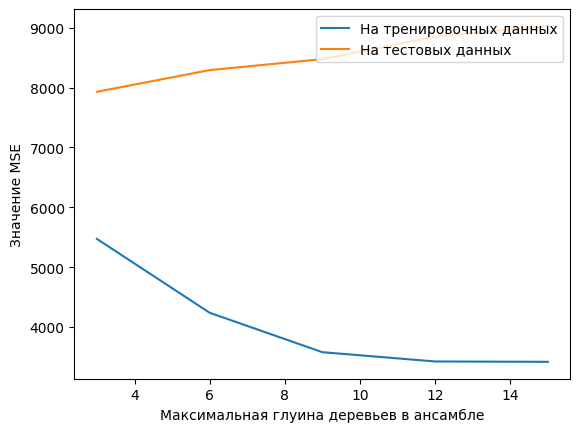

In [31]:
# строим график
plt.xlabel('Максимальная глуина деревьев в ансамбле')
plt.ylabel('Значение MSE')
plt.plot(max_depth, [i[0] for i in rez], label='На тренировочных данных')
plt.plot(max_depth, [i[1] for i in rez], label='На тестовых данных')
plt.legend(loc='upper right')
plt.show()

Мы видим, что ошибка на тестовых данных уменьшается, а на тестовых - растёт. Вывод - при увеличении максимальной глубины деревьев в ансамбле происходит переобучение, что логично, ведь деревья склонны к  нему

Задача 2.

Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

На каждой итерации мы будем определять случайные индексы без повторений (random.choise) и на основе их каждый раз делать новую убучающую подвыборку

In [58]:
# "игрушечный" датасет
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

# обучающая и тестовая выборка
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)


# создадим модифицированную функцию на основе gb_fit
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    trees = []
    train_errors = []
    test_errors = []
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        if len(trees) == 0:
            tree.fit(X_train, y_train)  
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:

            #
            # выберем индексы новой случайной подвыборки
            indexes = np.random.choice(len(X_train), len(X_train) // 2, replace=False)
            x_new_train, y_new_train = X_train[indexes], y_train[indexes]
            # Получим ответы на нашей случайной подвыборке
            target = gb_predict(x_new_train, trees, eta)
            # обучаем на сдвиг
            tree.fit(x_new_train, residual(y_new_train, target))
            #
            
            train_errors.append(mean_squared_error(y_new_train, gb_predict(x_new_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        trees.append(tree)
    return trees, train_errors, test_errors


In [71]:
n_trees = 50
max_depth = 3
eta = 0.1

# обучим лес на нашей 
trees, train_errors, test_errors = sgb_fit(n_trees, m_d, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)



Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 39.774188694465735
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3169.802829254079


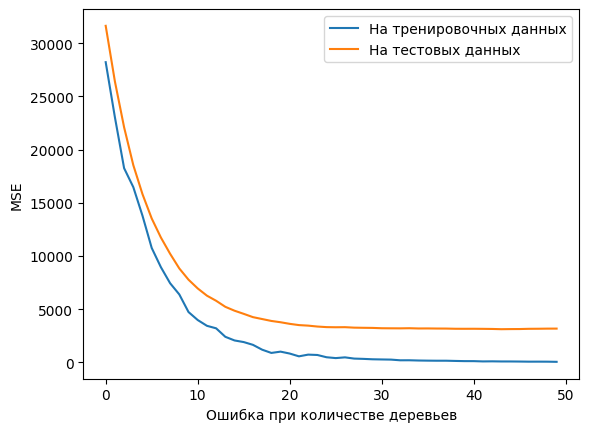

In [72]:
# график зависимоти ошбики от числа итераций ( количества деревьев в лесу)
plt.xlabel('Ошибка при количестве деревьев')
plt.ylabel('MSE')
plt.plot(list(range(n_trees)), train_errors, label='На тренировочных данных')
plt.plot(list(range(n_trees)), test_errors, label='На тестовых данных')
plt.legend(loc='upper right')
plt.show()